In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import os
import torchinfo
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


cuda


In [2]:
# train_def_path = "/kaggle/input/real-life-industrial-dataset-of-casting-product/casting_data/casting_data/train/def_front"
# train_ok_path = "/kaggle/input/real-life-industrial-dataset-of-casting-product/casting_data/casting_data/train/ok_front"
val_def_path = "/kaggle/input/real-life-industrial-dataset-of-casting-product/casting_data/casting_data/test/def_front"
val_ok_path = "/kaggle/input/real-life-industrial-dataset-of-casting-product/casting_data/casting_data/test/ok_front"

In [3]:
class Data(Dataset):
    def __init__(self, def_path, ok_path):
        self.def_path = def_path
        self.ok_path = ok_path
        self.def_imgs = np.array([os.path.join(self.def_path, i) for i in os.listdir(self.def_path)])
        self.ok_imgs = np.array([os.path.join(self.ok_path, i) for i in os.listdir(self.ok_path)])
        self.all_imgs = np.concatenate((self.def_imgs, self.ok_imgs))
        np.random.shuffle(self.all_imgs)
    def __len__(self):
        return len(self.all_imgs)
        
    def __getitem__(self, idx):
        img_path = self.all_imgs[idx]
        img = torch.tensor(cv.cvtColor(cv.imread(img_path), cv.COLOR_BGR2RGB)).type(torch.FloatTensor) #HWC
        img = torch.permute(img, (2,0,1)) #CHW
        if img_path in self.def_imgs: y = [0,1] #[0th index repr ok]
        elif img_path in self.ok_imgs: y = [1,0]
        return img, torch.tensor(y).type(torch.FloatTensor)

# train_data = Data(train_def_path, train_ok_path)
val_data = Data(val_def_path, val_ok_path)

In [4]:
class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3),
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=1024, kernel_size=3),
            nn.Dropout2d(p=0.2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.BatchNorm2d(num_features = 1024),
            nn.Conv2d(in_channels=1024, out_channels=128, kernel_size=1),
            nn.Flatten(),
            nn.Dropout(p=0.5),
            nn.LazyLinear(out_features=256),
            nn.Sigmoid(),
            nn.Linear(in_features=256, out_features=128),
            nn.Sigmoid(),
            nn.Linear(in_features = 128, out_features=64),
            nn.Sigmoid(),
            nn.Linear(in_features=64, out_features=2),
            nn.Softmax(dim=1)
        )
    def forward(self, x):
        return self.net(x)

model = torch.load('/kaggle/input/defect-insp-model/model.pt')
print(torchinfo.summary(model, (32, 3, 300, 300)))

Layer (type:depth-idx)                   Output Shape              Param #
Classifier                               [32, 2]                   --
├─Sequential: 1-1                        [32, 2]                   --
│    └─Conv2d: 2-1                       [32, 32, 298, 298]        896
│    └─ReLU: 2-2                         [32, 32, 298, 298]        --
│    └─Conv2d: 2-3                       [32, 64, 296, 296]        18,496
│    └─ReLU: 2-4                         [32, 64, 296, 296]        --
│    └─MaxPool2d: 2-5                    [32, 64, 148, 148]        --
│    └─Conv2d: 2-6                       [32, 128, 146, 146]       73,856
│    └─ReLU: 2-7                         [32, 128, 146, 146]       --
│    └─Conv2d: 2-8                       [32, 256, 144, 144]       295,168
│    └─ReLU: 2-9                         [32, 256, 144, 144]       --
│    └─MaxPool2d: 2-10                   [32, 256, 72, 72]         --
│    └─Conv2d: 2-11                      [32, 512, 70, 70]         1,18

In [5]:
BATCH_SIZE = 1
val_loader = DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

model = model.to(device)   
y_true = []
y_pred = []
model.eval()
for batch, (x,y) in enumerate(val_loader):
    x,y = x.to(device), y.to(device)
    x = x/255
    pred = model(x)
    pred = torch.argmax(pred).item()
    y = torch.argmax(y).item()
    y_true.append(y)
    y_pred.append(pred)
y_true, y_pred = np.array(y_true), np.array(y_pred)
acc_score = accuracy_score(y_true, y_pred)
conf_mat = confusion_matrix(y_true, y_pred)

In [6]:
print(f'Model accuracy on test set: {acc_score}')
print(f'Confusion Matrix: \n{conf_mat}')

Model accuracy on test set: 0.9888111888111888
Confusion Matrix: 
[[262   0]
 [  8 445]]


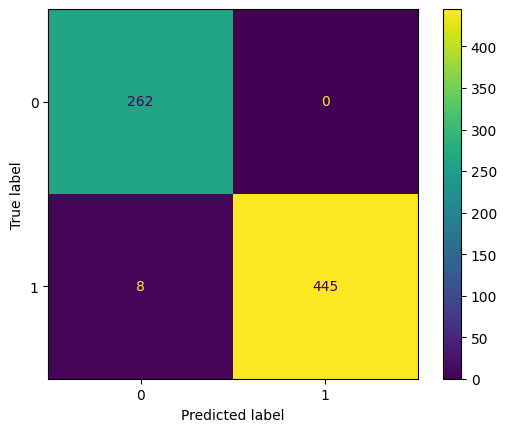

In [7]:
ConfusionMatrixDisplay.from_predictions(y_true, y_pred)
plt.show()